# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module

# get the new stuff
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.dataset import GeneExpressionDataset
# from src.engine.train import train_dgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

## Option 2: Using TCGA

In [6]:
mrna_raw = pd.read_table("data/TCGA_counts/TCGA_mrna_counts_match.tsv", sep='\t')
mrna_anno = pd.read_table("data/TCGA_counts/TCGA_sample_anno_match.tsv", sep='\t')

In [7]:
mrna_raw.head()

In [8]:
mrna_anno.head()

In [9]:
mrna_raw_t = mrna_raw.T
mrna_raw_t["primary_site"] = mrna_anno["primary_site"]

In [10]:
mrna_raw_t.head()

In [ ]:
pd.write_csv(mrna_raw_t, "data/TCGA_mrna_counts_match_transposed.tsv", sep='\t')

## Data Loader

In [11]:
# make data split for train and validation sets
out_dim = gtex_raw.shape[1]-1
train_ratio = 0.9
train_data = gtex_raw.iloc[:int(train_ratio*len(gtex_raw)),:]
test_data = gtex_raw.iloc[int(train_ratio*len(gtex_raw)):,:]

# define scaling for NB
# each sample gets a scaling factor
scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
test_scaling_factors = torch.mean(torch.Tensor(test_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)

# make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data),
                                          batch_size=256,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data),
                                          batch_size=256,
                                          shuffle=True)

In [12]:
print(train_data.shape)
print(test_data.shape)
print(out_dim)

(23528, 5001)
(2615, 5001)
5000


In [13]:
for x, lib, index in train_loader:
    print(x.shape)
    print(lib.shape)
    print(lib)
    print(index.shape)
    print(index)
    break

torch.Size([256, 5000])
torch.Size([256])
tensor([273809.5000, 243205.8438, 368477.5938, 230780.7031, 229770.7969,
        358382.7812, 125434.7812, 295038.1250, 326396.1562, 319433.4062,
        215099.0625, 284019.5625, 180254.4062, 213562.6875, 302271.3438,
        219977.9844, 550044.8750, 198442.4375, 239778.4375, 317774.3750,
        388889.6875, 235792.8438, 290143.5938, 199943.7812, 292272.5625,
        281210.4375, 268411.1875, 325535.4688, 134953.8594, 233651.1250,
        463870.1562, 231464.0938, 248763.3438, 404320.7188, 267919.2188,
        182472.7031, 428405.4375, 325193.2188, 247754.1875, 212924.1719,
        615127.5625, 257121.5625, 258720.5312, 267365.5938, 222589.2344,
        251978.6562, 241263.3281, 223659.6250, 174830.5312, 190650.3438,
        215854.6719, 215943.7031, 150388.4375, 239949.5156, 213293.7031,
        319948.2500, 345512.4062, 220083.2500, 130188.4688, 188660.4844,
        215953.7656, 261352.1406, 238485.7812, 447560.0312, 337858.7500,
        4

In [14]:
n_tissues = len(gtex_raw["tissue"].unique())
n_tissues # bit too high with cancer types
n_tissues = 30

In [15]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 128, 128]
reduction_type = "sum" # output loss reduction

# Decoder Setup

In [16]:
# decoder setup

# set up an output module for the expression data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim)
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="mean")
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_gex_layer]).to(device)

# Specific code (DGD collection and training loop) as examples

Can be changed depending on the model, I assume

## DGD Class

In [17]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self, decoder, n_mix, rep_dim, gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder = decoder
        self.rep_dim = rep_dim      # Dimension of representation

        self.gmm = GaussianMixture(n_mix, rep_dim, **gmm_spec)
        self.train_rep = None
        self.val_rep = None

    def forward(self,z):
        return self.decoder(z)

    def loss(self, z, y, target, scale, gmm_loss=True, reduction="sum"):
        self.dec_loss = self.decoder.loss(y, target, scale, reduction=reduction)
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
            return self.dec_loss, self.gmm_loss
        else:
            return self.dec_loss, None
    
    def forward_and_loss(self,z,target,scale,gmm_loss=True,reduction="sum"):
        y = self.decoder(z)
        return self.loss(z, y, target, scale, gmm_loss, reduction)

## Training Function

In [18]:
# write a minimal training function

def train_dgd(dgd, train_loader, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,reduction_type="sum"):
    if reduction_type == "sum":
        tlen=len(train_loader.dataset)*dgd.decoder.n_out_features
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)*dgd.decoder.n_out_features
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
    else:
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)
    
    Ntrain=len(train_loader.dataset)
    Nvalidation=len(validation_loader.dataset)
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim, Ntrain).to(device)
    Nvalidation=len(validation_loader.dataset)
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim, Nvalidation).to(device)

    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'])
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[]}
    best_loss = 1.e20

    # length of dataloader
    tlen = len(train_loader)
    vlen = len(validation_loader)
    gmm_loss = True
    dgd.train()
    
    for epoch in range(nepochs):
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)

        train_rep_optimizer.zero_grad()
        dgd.train()

        for x, lib, index in train_loader:
            dec_optimizer.zero_grad()
            if gmm_loss: 
                gmm_optimizer.zero_grad()
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.train_rep(index), [x.to(device)], [lib.unsqueeze(1).to(device)],
                                        gmm_loss = gmm_loss, reduction=reduction_type)
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
            dec_optimizer.step()
            if gmm_loss: 
                gmm_optimizer.step()
            #return None
        train_rep_optimizer.step()

        loss_tab["Train recon"][-1] /= tlen
        loss_tab["GMM train"][-1] /= tlen_gmm

        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()
        dgd.eval()
        for x, lib, index in validation_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.val_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
        val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm

        if pr > 0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
    
    return loss_tab

# Train and Test the model

## Params and DGD

In [19]:
# init a DGD model

gmm_mean_scale = 5.0
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder = decoder,
        n_mix = n_tissues,
        rep_dim = latent_dim,
        gmm_spec = {"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

## Training loop

In [20]:
# train for 10 epochs and plot learning curves
n_epochs = 10
pr = 1  # how often to print

loss_tab = train_dgd(
    dgd, train_loader, test_loader, device,
    learning_rates={'dec': 0.001, 'rep': 0.01, 'gmm': 0.01},
    weight_decay=0., nepochs=n_epochs, pr=pr, reduction_type=reduction_type
)

# stuff is running but I have to check the loss normalization for printing and plotting, they seem a bit large

1 17371365.38043478 15478719.568181818
2 16482767.413043479 15423604.5
3 16414711.77173913 15365730.704545455
4 16358067.47826087 15350201.386363637
5 16306614.380434783 15291147.136363637
6 16265257.836956521 15235566.136363637
7 16221040.847826088 15206807.0
8 16186183.152173912 15166338.545454545
9 16153721.52173913 15155122.659090908
10 16121636.923913043 15111581.227272727


# Plotting

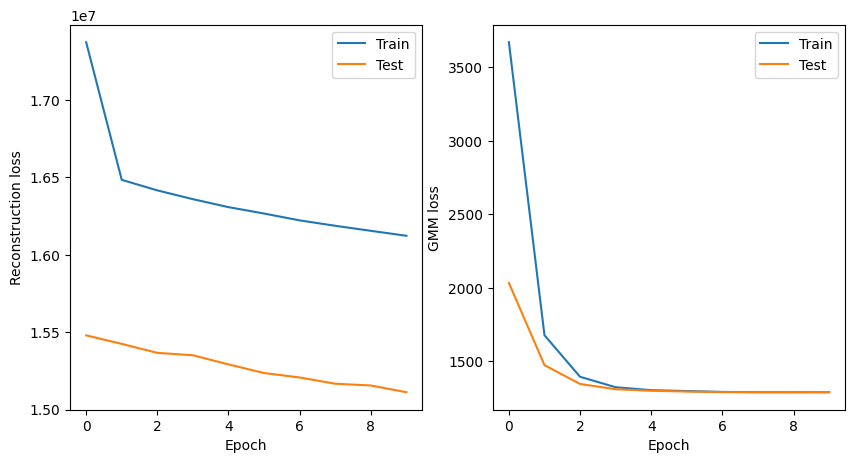

In [21]:
import matplotlib.pyplot as plt
# make 2 subplots with recon and gmm loss curves

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()
plt.show()

In [27]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=5000, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [26]:
for x, lib, index in train_loader:
    print(x)
    print(lib)
    break

tensor([[1.8539e+05, 1.3371e+05, 3.0400e+02,  ..., 1.4713e+05, 1.9333e+05,
         9.8169e+04],
        [1.0008e+05, 9.6027e+04, 0.0000e+00,  ..., 5.9324e+04, 2.1931e+05,
         4.8810e+04],
        [1.7654e+05, 1.8316e+05, 0.0000e+00,  ..., 2.7448e+05, 2.8860e+05,
         1.4679e+05],
        ...,
        [2.3594e+05, 1.9534e+05, 0.0000e+00,  ..., 1.9461e+05, 2.5457e+05,
         1.0756e+05],
        [2.6800e+05, 2.1225e+05, 6.8000e+01,  ..., 1.5712e+05, 1.8459e+05,
         7.9051e+04],
        [1.1574e+05, 3.9748e+04, 5.2220e+03,  ..., 1.5161e+05, 5.8636e+04,
         6.1683e+04]])
tensor([322891.4062, 229277.2812, 369438.9062, 312785.0000, 135260.7031,
        207156.9219, 228916.7812, 183600.3281, 327484.5312, 203613.5156,
        102308.9219, 361049.0000, 276937.2812, 305857.6250, 262538.8438,
        236070.8281, 291334.2812, 327696.6875, 127999.8750, 246881.1562,
        279307.9062, 201884.7344, 341380.1875, 251563.0781, 266200.5625,
        223588.5000, 274445.3750, 15808